In [1]:
#!pip install nltk
#!pip install emoji
#!pip install xgboost
from wordcloud import WordCloud, STOPWORDS
import requests
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
import numpy as np 
pd.set_option('display.max_colwidth', None)
from time import time
import re
import string
import os
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

In [2]:
#result=requests.get('http://159.65.217.53:3001/brandbuzz/segusimiento/Pruebatecnica/LWL05x51mHOMT9GtOqnHHgqWzc72')

In [3]:
#df = pd.DataFrame(result.json())
#df.to_csv('datos_bavaria.csv', sep='\t', encoding='utf-8')
df=pd.read_csv('C:/Users/manuel.pachon/Desktop/datos_bavaria_1.csv', encoding='latin-1')

In [4]:
df[['Campañas','SENTIMENT','CONTENT','MEDIA_PROVIDER']].head()

,Campañas,SENTIMENT,CONTENT,MEDIA_PROVIDER
0,USUARIO,Positive,Esquipo lokillo excelente,Facebook Comments
1,USUARIO,Negative,Qué aburridos,Facebook Comments
2,USUARIO,Neutral,Hassam,Facebook Comments
3,USUARIO,Positive,no estuvo entretenido,Facebook Comments
4,USUARIO,Positive,"excelente show, gracias por esta labor, boto por Lokillo.",Facebook Comments


# **Análisis descriptivo de los datos**

Se observa que hay de 563 reacciones positivas, 374 neutrales y 63 negativas.

SENTIMENT
Positive     563
Neutral      374
Negative      63
dtype: int64


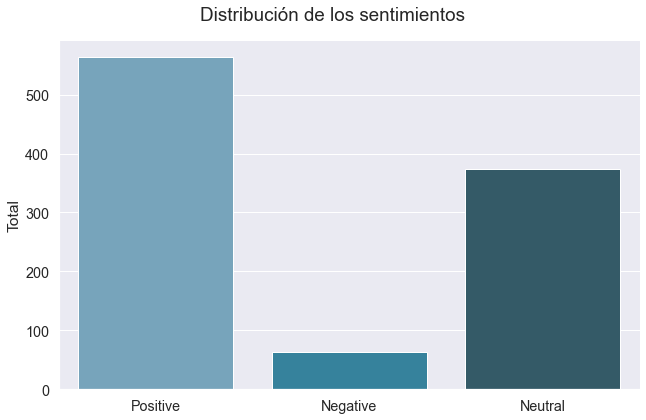

In [5]:
print(df[['SENTIMENT']].value_counts())
sent=sns.catplot(x="SENTIMENT", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
sent.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
sent.fig.suptitle('Distribución de los sentimientos')
sent.set_axis_labels("", "Total")
plt.show();

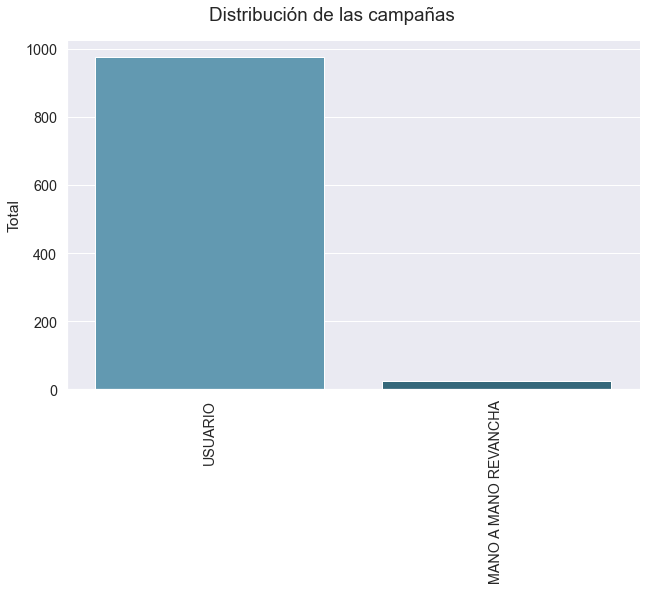

In [6]:
camp=sns.catplot(x="Campañas", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
camp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
camp.fig.suptitle('Distribución de las campañas')
camp.set_axis_labels("", "Total")
camp.set_xticklabels(rotation=90)

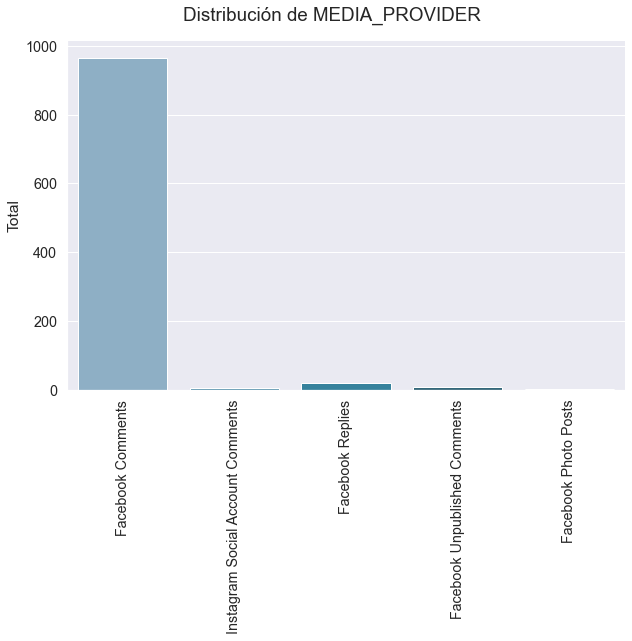

In [7]:
med=sns.catplot(x="MEDIA_PROVIDER", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
med.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
med.fig.suptitle('Distribución de MEDIA_PROVIDER')
med.set_axis_labels("", "Total")
med.set_xticklabels(rotation=90)

Casi todos los comentarios de CONTENT pertenecen a la campaña USUARIO y al MEDIA_PROVIDER facebook.

# Diferencias entre las diferentes categorías de SENTIMENT

In [8]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'conteo_palabras': count_words
                           , 'conteo_menciones': count_mentions
                           , 'conteo_hashtags': count_hashtags
                           , 'conteo_palabras_mayusculas': count_capital_words
                           , 'conteo_exclam_interog': count_excl_quest_marks
                           , 'conteo_urls': count_urls
                           , 'conteo_emojis': count_emojis
                          })
        
        return df
tc = TextCounts()
df_eda = tc.fit_transform(df.CONTENT.astype(str))
df_eda['SENTIMENT'] = df.SENTIMENT

In [9]:
def show_dist(df, col):
    print('Estadísticas descriptivas para el {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('SENTIMENT')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='SENTIMENT', size=5, hue='SENTIMENT', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Estadísticas descriptivas para el conteo_palabras
-------------------------------------
           count      mean       std  min  25%  50%  75%   max
SENTIMENT                                                     
Negative    63.0  6.190476  4.075328  1.0  4.0  6.0  8.0  25.0
Neutral    374.0  2.251337  2.871873  0.0  1.0  1.0  3.0  31.0
Positive   563.0  5.584369  4.495696  1.0  2.0  4.0  7.0  41.0


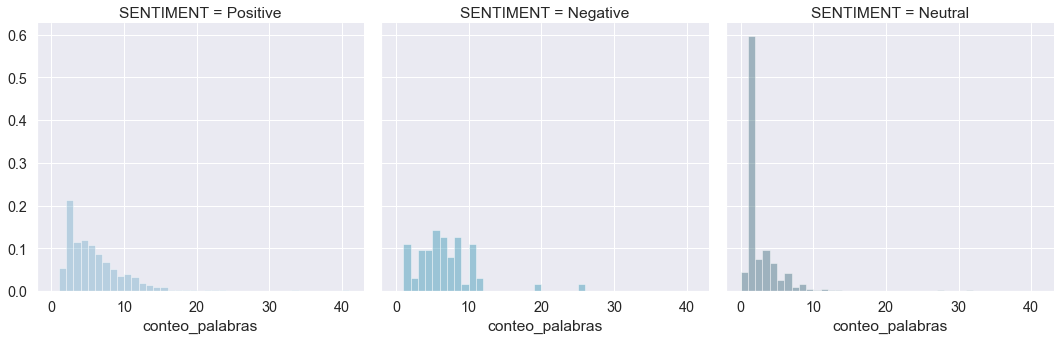

Estadísticas descriptivas para el conteo_palabras_mayusculas
------------------------------------------------
           count      mean       std  min  25%  50%  75%   max
SENTIMENT                                                     
Negative    63.0  0.015873  0.125988  0.0  0.0  0.0  0.0   1.0
Neutral    374.0  0.117647  1.353006  0.0  0.0  0.0  0.0  25.0
Positive   563.0  0.033748  0.382813  0.0  0.0  0.0  0.0   6.0


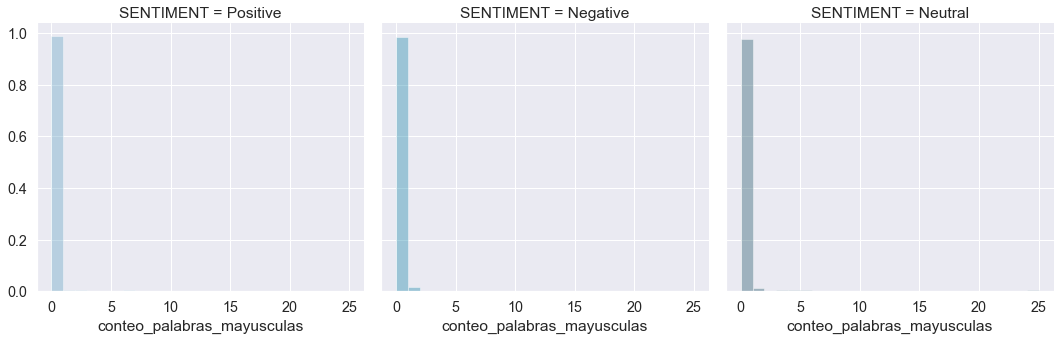

In [10]:
show_dist(df_eda,'conteo_palabras')
show_dist(df_eda,'conteo_palabras_mayusculas')

Se observa que no hay grandes diferencias entre la cantidad de palabras en las tres categorías de SENTIMENT, más del 75% de textos en todas las categorías tienen menos de 10 palabras.
Observando la forma de la distribución se puede decir que los comentarios negativos, tienen más palabras al compararse con las otras dos categorías.
Por lo menos la mitad de los comentarios neutrales tienen una palabra o ninguna.
En el resto de clasificaciones (menciones, hashtags, palabras en mayúscula, signos de exclamación o interrogación, URLs y emojis) no se observan diferencias entre grupos y también se observa que muy pocos textos en CONTENT contienen alguna de las clasificaciones.
Los comentarios no tienen menciones (palabras seguidas por '@'), hashtags ni URLs. Estos tienen pocos emojis, signos de interrogación ni exclamación y tampoco palabras en mayúscula. No se observan diferencias en estas clasificaciones entre las categorías de SENTIMENT.

# Preprocesamiento 

A continuación se van a convertir todas las mayúsculas en minúsculas, se eliminaran las tildes, las URLs y los signos de puntuación.

In [11]:
## Vamos a eliminar las URL
df['CONTENT']=df['CONTENT'].astype(str)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub(r'http\S+', '',x)
)

In [12]:
# Convertimos todo el texto a minúscula

df['CONTENT'] = df.CONTENT.apply(lambda x: x.lower())

In [13]:
## Reemplazar tildes y puntuación y cambiar algunas palabras

df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('á', 'a',  x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('é', 'e',  x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('í', 'i',  x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('ó', 'o',  x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('ú', 'u',  x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub(r'[^\w\s]','',x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('hassan','hassam',x)
)
df['CONTENT'] = df['CONTENT'].apply(
    lambda x: re.sub('hasam','hassam',x)
)

# Frecuencia de las palabras en todo el dataset y en las diferentes categorías de SENTIMENT

<AxesSubplot:title={'center':'Frecuencia de las palabras en todo el dataset'}>

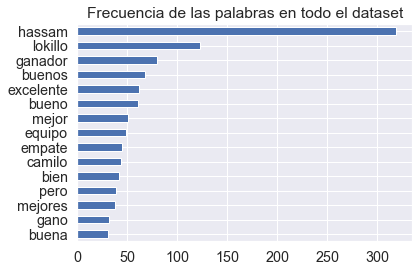

In [14]:
texto=''
for i in df['CONTENT']:
    texto += i+' '
texto=re.sub('hassan','hassam',texto)
tokens = nltk.tokenize.word_tokenize(texto)
pd.Series([w for w in tokens if len(w) > 3]).value_counts()
pd.Series([w for w in tokens if len(w) > 3]).value_counts()[:15][::-1].plot(kind='barh',title='Frecuencia de las palabras en todo el dataset')

<AxesSubplot:title={'center':'Frecuencia de las palabras en los comentarios negativos'}>

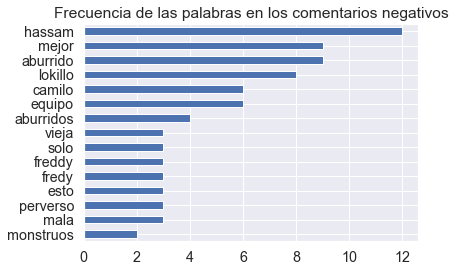

In [15]:
texto=''
negativos=df[df['SENTIMENT']=='Negative']
for i in negativos['CONTENT']:
    texto += i+' '
texto=re.sub('hassan','hassam',texto)
tokens = nltk.tokenize.word_tokenize(texto)
pd.Series([w for w in tokens if len(w) > 3]).value_counts()
pd.Series([w for w in tokens if len(w) > 3]).value_counts()[:15][::-1].plot(kind='barh',title='Frecuencia de las palabras en los comentarios negativos')

<AxesSubplot:title={'center':'Frecuencia de las palabras en los comentarios neutrales'}>

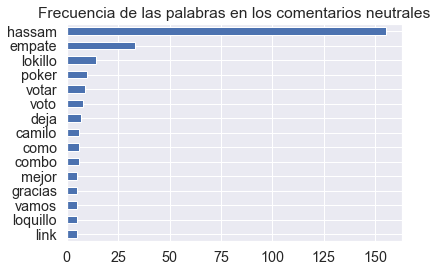

In [16]:
texto=''
neutrales=df[df['SENTIMENT']=='Neutral']
for i in neutrales['CONTENT']:
    texto += i+' '
texto=re.sub('hassan','hassam',texto)
tokens = nltk.tokenize.word_tokenize(texto)
pd.Series([w for w in tokens if len(w) > 3]).value_counts()
pd.Series([w for w in tokens if len(w) > 3]).value_counts()[:15][::-1].plot(kind='barh',title='Frecuencia de las palabras en los comentarios neutrales')

<AxesSubplot:title={'center':'Frecuencia de las palabras en los comentarios positivos'}>

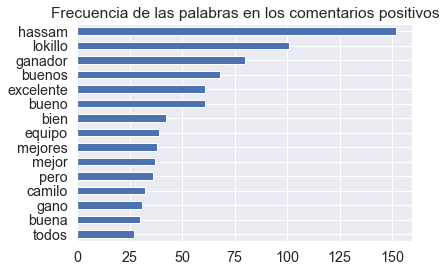

In [17]:
texto=''
positivos=df[df['SENTIMENT']=='Positive']
for i in positivos['CONTENT']:
    texto += i+' '
texto=re.sub('hassan','hassam',texto)
tokens = nltk.tokenize.word_tokenize(texto)
pd.Series([w for w in tokens if len(w) > 3]).value_counts()
pd.Series([w for w in tokens if len(w) > 3]).value_counts()[:15][::-1].plot(kind='barh',title='Frecuencia de las palabras en los comentarios positivos')

En todas las categorías la palabra hassam es la más frecuente, esto muestra la popularidad de este comediante. Sin embargo, la mención de Hassam no parece estar asociada con ningún sentimiento en particular. Se observa lo mismo para el comediante Lokillo.

En los comentarios negativos se encuentran palabras relacionadas con el desinterés o el aburrimiento con respecto a los comediantes y al programa.

En los comentarios neutrales destaca la palabra empate y palabras relacionadas con votar.

Las palabras más optimistas se encuentran en la categoría de sentimientos positivos, como por ejemplo, las palabras excelente o bueno. Las personas que escribieron estos comentarios estarían más involucradas con el programa y su contenido.


# Clasificador Support Vector Machine con kernels lineal y rbf

In [18]:
# Para poder usar los algoritmos de análisis de sentimientos, se deben eliminar las palabras conocidas como stopwords
# que son artículos o preposiciones que no aportan al sentido de los comentarios

stop = stopwords.words('spanish')
df["CONTENT"]=df["CONTENT"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
df['CONTENT']

0                        esquipo lokillo excelente
1                                        aburridos
2                                           hassam
3                                      entretenido
4        excelente show gracias labor boto lokillo
                          ...                     
995                                         siiiii
996                                         empate
997                                         empate
998                                     deja botar
999    hassam empate mitad premio cada fundaciones
Name: CONTENT, Length: 1000, dtype: object

In [19]:
# Se usan el 30% de los datos para validación y el 70% restante para el entrenamiendo
# Se codifican las clases de SENTIMENT para que sean enteros

asignacion_1 = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
def decode_sentiment(label):
    return asignacion_1[label]
df.target = df.SENTIMENT.apply(lambda x: decode_sentiment(x))
x_train, x_test, y_train, y_test = train_test_split(
     df.CONTENT, df.target, test_size=0.3, shuffle=False, random_state=11)

In [20]:
# Crear vectores de características, esto asigna un número a cada palabra de nuestro dataset 

vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

In [21]:
# Clasificador SVM con kernel lineal

classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, y_train)
prediction_linear = classifier_linear.predict(test_vectors)
report = classification_report(y_test, prediction_linear, output_dict=True)
report

{'-1': {'precision': 1.0,
  'recall': 0.14285714285714285,
  'f1-score': 0.25,
  'support': 7},
 '0': {'precision': 0.8391959798994975,
  'recall': 0.8789473684210526,
  'f1-score': 0.858611825192802,
  'support': 190},
 '1': {'precision': 0.75,
  'recall': 0.7281553398058253,
  'f1-score': 0.7389162561576353,
  'support': 103},
 'accuracy': 0.81,
 'macro avg': {'precision': 0.8630653266331659,
  'recall': 0.5833199503613402,
  'f1-score': 0.615842693783479,
  'support': 300},
 'weighted avg': {'precision': 0.8123241206030151,
  'recall': 0.81,
  'f1-score': 0.803315403902896,
  'support': 300}}

In [22]:
# Matriz de confusión 
# La matriz de confusión nos indica qué tan bien clasificó nuestro algoritmo a los datos de validación

confusion = confusion_matrix(y_test, prediction_linear)
print(confusion)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction_linear)))

[[  1   4   2]
 [  0 167  23]
 [  0  28  75]]
Accuracy: 0.81


In [23]:
# Clasificador SVM con kernel rbf

classifier_rbf = svm.SVC(kernel='rbf',gamma=0.3)
classifier_rbf.fit(train_vectors, y_train)
prediction_rbf = classifier_rbf.predict(test_vectors)
report = classification_report(y_test, prediction_rbf, output_dict=True)
report

{'-1': {'precision': 1.0,
  'recall': 0.14285714285714285,
  'f1-score': 0.25,
  'support': 7},
 '0': {'precision': 0.9556962025316456,
  'recall': 0.7947368421052632,
  'f1-score': 0.867816091954023,
  'support': 190},
 '1': {'precision': 0.7092198581560284,
  'recall': 0.970873786407767,
  'f1-score': 0.819672131147541,
  'support': 103},
 'accuracy': 0.84,
 'macro avg': {'precision': 0.8883053535625579,
  'recall': 0.6361559237900577,
  'f1-score': 0.6458294077005213,
  'support': 300},
 'weighted avg': {'precision': 0.8721064129036119,
  'recall': 0.84,
  'f1-score': 0.8368709565982037,
  'support': 300}}

In [24]:
# Matriz de confusión 

confusion = confusion_matrix(y_test, prediction_rbf)
print(confusion)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction_rbf)))

[[  1   4   2]
 [  0 151  39]
 [  0   3 100]]
Accuracy: 0.84


### Validación cruzada para el kernel lineal

La validación cruzada nos permite probar nuestro clasificador en diferentes muestras aleatorias de los datos. Se crean $n$ muestras de entrenamiento y $n$ muestras de validación (en este caso escogemos $n=5$) de forma que todos los datos se encuentren una vez en la muestra de entrenamiento y una vez en la muestra de validación.
Esto permite observar si el clasificador funciona bien en todos los datos o si el accuracy obtenido solo se tiene para los datos de entrenamiento y validación escogidos inicialmente.

In [25]:
clf_lineal = svm.SVC(kernel='linear')
train_vectors = vectorizer.fit_transform(df['CONTENT'])
cv_scores=cross_val_score(clf_lineal, train_vectors,df.target,cv=5)
print('Cross-validation (accuracy)', cross_val_score(clf_lineal, train_vectors,
                                                     df.target,
                                                     cv=5))
print('Promedio cross-validation score (5-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation (accuracy) [0.815 0.88  0.85  0.835 0.76 ]
Promedio cross-validation score (5-fold): 0.828


### Validación cruzada para el kernel rbf

In [26]:
clf_rbf = svm.SVC(kernel='rbf',gamma=0.3)
train_vectors = vectorizer.fit_transform(df['CONTENT'])
cv_scores=cross_val_score(clf_rbf, train_vectors,df.target,cv=5)
print('Cross-validation (accuracy)', cross_val_score(clf_rbf, train_vectors,
                                                     df.target,
                                                     cv=5))
print('Promedio cross-validation score (5-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation (accuracy) [0.805 0.855 0.84  0.845 0.75 ]
Promedio cross-validation score (5-fold): 0.819


# Clasificador árboles de decisión

In [27]:
train_vectors = vectorizer.fit_transform(x_train)
classifier_random = DecisionTreeClassifier().fit(train_vectors, y_train)
prediction_random=classifier_random.predict(test_vectors)
print('Accuracy del clasificador árbol de decisión en la muestra de entrenamiento: {:.2f}'
     .format(classifier_random.score(train_vectors, y_train)))
print('Accuracy del clasificador árbol de decisión en la muestra de validación: {:.2f}'
     .format(classifier_random.score(test_vectors, y_test)))
report = classification_report(y_test, prediction_random, output_dict=True)
report

Accuracy del clasificador árbol de decisión en la muestra de entrenamiento: 0.92
Accuracy del clasificador árbol de decisión en la muestra de validación: 0.81


{'-1': {'precision': 0.1,
  'recall': 0.14285714285714285,
  'f1-score': 0.11764705882352941,
  'support': 7},
 '0': {'precision': 0.8382352941176471,
  'recall': 0.9,
  'f1-score': 0.8680203045685279,
  'support': 190},
 '1': {'precision': 0.8372093023255814,
  'recall': 0.6990291262135923,
  'f1-score': 0.761904761904762,
  'support': 103},
 'accuracy': 0.8133333333333334,
 'macro avg': {'precision': 0.5918148654810761,
  'recall': 0.5806287563569117,
  'f1-score': 0.5825240417656065,
  'support': 300},
 'weighted avg': {'precision': 0.8206575467396261,
  'recall': 0.8133333333333334,
  'f1-score': 0.8140785925199182,
  'support': 300}}

In [28]:
# matriz de confusión

confusion = confusion_matrix(y_test, prediction_random)
print(confusion)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, prediction_random)))

[[  1   4   2]
 [  7 171  12]
 [  2  29  72]]
Accuracy: 0.81


### Validación cruzada para el árbol de decisión

In [29]:
clf_random_cv = DecisionTreeClassifier()
train_vectors = vectorizer.fit_transform(df['CONTENT'])
cv_scores=cross_val_score(clf_random_cv, train_vectors,df.target,cv=5)
print('Cross-validation (accuracy)', cross_val_score(clf_random_cv, train_vectors,
                                                     df.target,
                                                     cv=5))
print('Promedio cross-validation score (5-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation (accuracy) [0.8   0.815 0.855 0.82  0.725]
Promedio cross-validation score (5-fold): 0.801


Debido al desbalance que se presenta en los datos (hay muy pocos comentarios negativos comparados con los neutrales y los positivos), el f1 score es una buena métrica para evaluar el desempeño de los tres clasificadores.
Los puntajes f1 para cada uno de los clasificadores son:

In [30]:
print('El f1 para el SVM con kernel lineal es: ',f1_score(y_test, prediction_linear, average='macro'))
print('El f1 para el SVM con kernel rbf es: ',f1_score(y_test, prediction_rbf, average='macro'))
print('El f1 para el árbol de decision es: ',f1_score(y_test, prediction_random, average='macro'))

El f1 para el SVM con kernel lineal es:  0.615842693783479
El f1 para el SVM con kernel rbf es:  0.6458294077005213
El f1 para el árbol de decision es:  0.5825240417656065


# Ejemplo de una predicción

Observemos qué sentimiento asignan los tres clasificadores a un pequeño comentario

In [31]:
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)
review_vector = vectorizer.transform(['un show aburrido en mi concepto no debería haber ningún ganador']) # vectorizing
print(classifier_rbf.predict(review_vector))
review_vector = vectorizer.transform(['un show aburrido en mi concepto no debería haber ningún ganador']) # vectorizing
print(classifier_random.predict(review_vector))
review_vector = vectorizer.transform(['un show aburrido en mi concepto no debería haber ningún ganador']) # vectorizing
print(classifier_linear.predict(review_vector))

[-1]
[-1]
[-1]


Como vemos, se clasificó nuestro comentario como negativo (-1) en todos los algoritmos.

# Conclusion

Los tres clasificadores se ejecutan de forma rápida y tienen resultados aceptables, observando el accuracy promedio obtenido usando validación cruzada, el mejor algoritmo de los escogidos (medido por el accuracy) es el SVM con un kernel rbf.
El SVM con kernel lineal tiene un mejor desempeño para clasificar comentarios neutrals, dependiendo del análisis costo-beneficio que se haga (por ejemplo, si clasificar correctamente los comentarios neutrals resulta más beneficioso que clasificar de manera correcta las otras dos categorías) podría resultar mejor usar el SVM con kernel linel a pesar de tener métricas ligeramente inferiores al kernel rbf.
El SVM con kernel rbf se ajusta mejor que los otros dos algoritmos a la naturaleza desbalanceada de los datos, esto se concluye del f1 score, por lo que finalmente este podría ser el algoritmo con el mejor desempeño.